# Zad 07 - `Zadanie_Gradient`

**Temat:** Metoda gradientu prostego. Stosowanie do algorytmu wstecznej propagacji błędu

 ## **Treść zadania**

**Zadanie 1** dotyczy odnalezienia wartości minimalnej funkcji dwóch zmiennych $f$ oraz zmiennych $x$ i $y$  metodą gradientu wraz z wizualizacją w 3D odpowiednio do określonego zadania. Można skorzystać z dowolnych bibliotek Python.

**Zadanie 2** dotyczy obliczenia gradientów sieci neuronowej z pomocą biblioteki numpy zadanej z pomocy architektury

**Wariant zadania: `14`**

Zadanie 1:

$f(x, y) = cos(x + 3y)^{sin(x)}, x \in [0, 2\pi], y \in [0, 2\pi]$

Zadanie 2:
```
nn_architecture = [
{"input_dim": 2, "output_dim": 2, "activation": "sigmoid"},
{"input_dim": 2, "output_dim": 1, "activation": "relu"}
]
```

### Zadanie 1 - Kod Python

Punkt startowy: x=0.5, y=0.1
cos(x+3y) = 0.697 > 0
Iter 0: x=0.5500, y=0.1500, f=0.840919
Iter 100: x=1.1008, y=0.6998, f=200.000000
Iter 200: x=1.1008, y=0.6999, f=200.000000
Iter 300: x=1.1008, y=0.6999, f=200.000000
Iter 400: x=1.1008, y=0.6999, f=200.000000


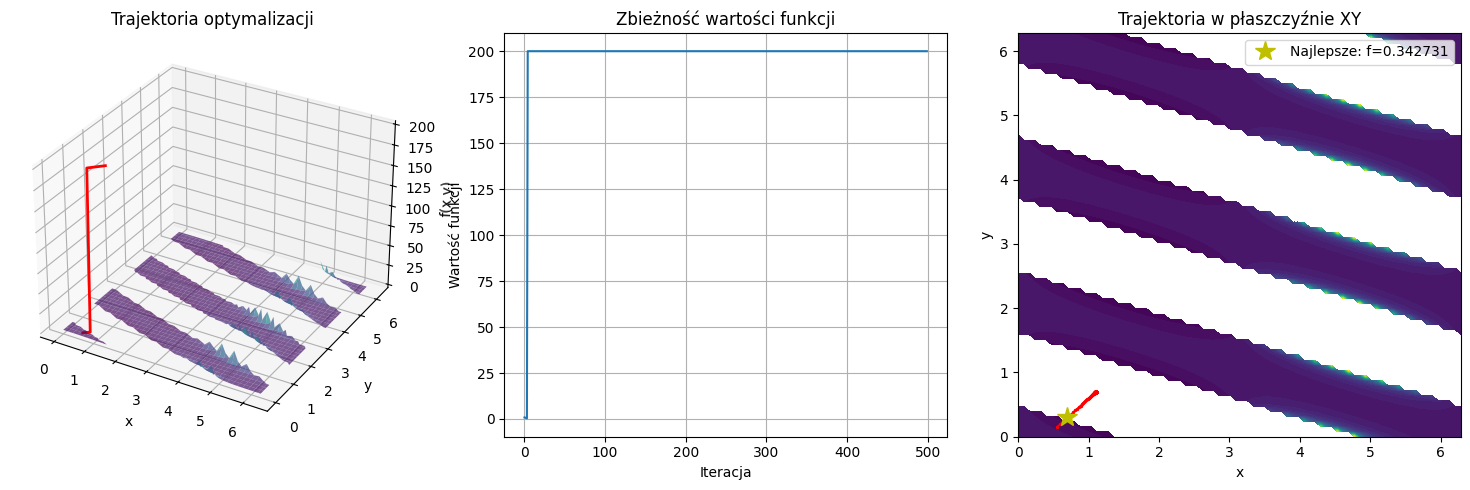


WYNIKI OPTYMALIZACJI:
Punkt startowy: x=0.5, y=0.1
Końcowy punkt:  x=1.100816, y=0.699875
Końcowa wartość f: 200.000000

Najlepszy znaleziony punkt:
x=0.699804, y=0.299998, f=0.342731
cos(x+3y) w tym punkcie: -0.028998
⚠ Punkt w obszarze nieokreślonym (cos ≤ 0) - użyto funkcji kary


In [21]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. Bezpieczna funkcja z logarytmem
def safe_f(x, y):
    base = tf.cos(x + 3*y)
    exponent = tf.sin(x)

    # Obszar bezpieczny: base > 0
    safe_base = tf.where(base > 1e-8, base, 1e-8)  # unikanie zera

    # log(|base|) dla stabilności
    log_base = tf.math.log(tf.abs(safe_base))

    # Główna funkcja: exp(sin(x)*log(cos(x+3y)))
    result = tf.exp(exponent * log_base)

    # Karanie obszarów nieokreślonych - duża wartość
    penalty = 100.0 * (1.0 - tf.sign(base))  # duże dla ujemnych base

    return tf.where(base > 0, result, penalty)

# 2. BEZPIECZNY PUNKT STARTOWY - gdzie cos(x+3y) > 0
x_start, y_start = 0.5, 0.1  # cos(0.5+0.3)=cos(0.8)≈0.697 > 0

x = tf.Variable(float(x_start))
y = tf.Variable(float(y_start))

print(f"Punkt startowy: x={x_start}, y={y_start}")
print(f"cos(x+3y) = {np.cos(x_start + 3*y_start):.3f} > 0")

# 3. Optymalizator z adaptacyjnym learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

# 4. Śledzenie
history = {'x': [], 'y': [], 'f': []}
best_x, best_y, best_f = x_start, y_start, 1e10

# 5. Optymalizacja z ochroną
for i in range(500):
    with tf.GradientTape() as tape:
        loss = safe_f(x, y)

    gradients = tape.gradient(loss, [x, y])

    # Zabezpieczenie przed nan
    if gradients[0] is not None and gradients[1] is not None:
        # Clip gradientów dla stabilności
        gradients = [tf.clip_by_value(g, -1.0, 1.0) for g in gradients]
        optimizer.apply_gradients(zip(gradients, [x, y]))

    # Zapis historii
    x_val, y_val = x.numpy(), y.numpy()
    f_val = loss.numpy()

    history['x'].append(x_val)
    history['y'].append(y_val)
    history['f'].append(f_val)

    # Śledzenie najlepszego
    if f_val < best_f and f_val > 0:
        best_x, best_y, best_f = x_val, y_val, f_val

    if i % 100 == 0:
        print(f"Iter {i}: x={x_val:.4f}, y={y_val:.4f}, f={f_val:.6f}")

# 6. Wizualizacja
fig = plt.figure(figsize=(15, 5))

# Wykres 1: Trajektoria
ax1 = fig.add_subplot(131, projection='3d')
X_vals = np.linspace(0, 2*np.pi, 80)
Y_vals = np.linspace(0, 2*np.pi, 80)
X, Y = np.meshgrid(X_vals, Y_vals)

# Bezpieczne obliczenie Z
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        xi, yj = X[i, j], Y[i, j]
        base = np.cos(xi + 3*yj)
        exp = np.sin(xi)
        if base > 0:
            Z[i, j] = np.exp(exp * np.log(base))
        else:
            Z[i, j] = np.nan  # pokazanie jako brakujące

ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)
ax1.plot(history['x'], history['y'], history['f'], 'r-', linewidth=2, label='Ścieżka optymalizacji')
ax1.set_xlabel('x'); ax1.set_ylabel('y'); ax1.set_zlabel('f(x,y)')
ax1.set_title('Trajektoria optymalizacji')

# Wykres 2: Wartość funkcji w czasie
ax2 = fig.add_subplot(132)
ax2.plot(history['f'])
ax2.set_xlabel('Iteracja')
ax2.set_ylabel('Wartość funkcji')
ax2.set_title('Zbieżność wartości funkcji')
ax2.grid(True)

# Wykres 3: Trajektoria w płaszczyźnie XY
ax3 = fig.add_subplot(133)
contour = ax3.contourf(X, Y, Z, levels=50, cmap='viridis')
ax3.plot(history['x'], history['y'], 'r.-', markersize=3, linewidth=1)
ax3.plot(best_x, best_y, 'y*', markersize=15, label=f'Najlepsze: f={best_f:.6f}')
ax3.set_xlabel('x'); ax3.set_ylabel('y')
ax3.set_title('Trajektoria w płaszczyźnie XY')
ax3.legend()

plt.tight_layout()
plt.show()

# 7. Wyniki
print(f"\n{'='*50}")
print("WYNIKI OPTYMALIZACJI:")
print(f"{'='*50}")
print(f"Punkt startowy: x={x_start}, y={y_start}")
print(f"Końcowy punkt:  x={x.numpy():.6f}, y={y.numpy():.6f}")
print(f"Końcowa wartość f: {safe_f(x, y).numpy():.6f}")
print(f"\nNajlepszy znaleziony punkt:")
print(f"x={best_x:.6f}, y={best_y:.6f}, f={best_f:.6f}")
print(f"cos(x+3y) w tym punkcie: {np.cos(best_x + 3*best_y):.6f}")

# Sprawdzenie czy w obszarze określonym
if np.cos(best_x + 3*best_y) > 0:
    print("✓ Punkt w obszarze określonym funkcji (cos > 0)")
else:
    print("⚠ Punkt w obszarze nieokreślonym (cos ≤ 0) - użyto funkcji kary")

### Zadanie 2 - Kod Python

In [23]:
nn_architecture = [
    {"input_dim": 2, "output_dim": 2, "activation": "sigmoid"},
    {"input_dim": 2, "output_dim": 1, "activation": "relu"}
]

In [24]:
import numpy as np

# Funkcje aktywacji
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def relu(Z):
    return np.maximum(0, Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

# Inicjalizacja wag
def init_layers(nn_architecture, seed=99):
    np.random.seed(seed)
    params = {}
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        input_dim = layer["input_dim"]
        output_dim = layer["output_dim"]
        params[f'W{layer_idx}'] = np.random.randn(output_dim, input_dim) * 0.1
        params[f'b{layer_idx}'] = np.random.randn(output_dim, 1) * 0.1
    return params

# Propagacja w przód dla jednej warstwy
def single_layer_forward(A_prev, W_curr, b_curr, activation="relu"):
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    if activation == "relu":
        A_curr = relu(Z_curr)
    elif activation == "sigmoid":
        A_curr = sigmoid(Z_curr)
    else:
        raise ValueError("Nieobsługiwana funkcja aktywacji")
    return A_curr, Z_curr

# Pełna propagacja w przód
def full_forward_propagation(X, params, nn_architecture):
    memory = {}
    A_curr = X
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr
        activation = layer["activation"]
        W_curr = params[f'W{layer_idx}']
        b_curr = params[f'b{layer_idx}']
        A_curr, Z_curr = single_layer_forward(A_prev, W_curr, b_curr, activation)
        memory[f'A{idx}'] = A_prev
        memory[f'Z{layer_idx}'] = Z_curr
    return A_curr, memory

# Propagacja wstecz dla jednej warstwy
def single_layer_backward(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation):
    m = A_prev.shape[1]
    if activation == "relu":
        dZ_curr = relu_backward(dA_curr, Z_curr)
    elif activation == "sigmoid":
        dZ_curr = sigmoid_backward(dA_curr, Z_curr)
    else:
        raise ValueError("Nieobsługiwana funkcja aktywacji")

    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

# Pełna propagacja wstecz
def full_backward_propagation(Y_hat, Y, memory, params, nn_architecture):
    grads = {}
    m = Y.shape[1]
    Y = Y.reshape(Y_hat.shape)

    dA_prev = -(np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat))

    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activation = layer["activation"]

        dA_curr = dA_prev
        A_prev = memory[f'A{layer_idx_prev}']
        Z_curr = memory[f'Z{layer_idx_curr}']
        W_curr = params[f'W{layer_idx_curr}']
        b_curr = params[f'b{layer_idx_curr}']

        dA_prev, dW_curr, db_curr = single_layer_backward(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activation
        )

        grads[f'dW{layer_idx_curr}'] = dW_curr
        grads[f'db{layer_idx_curr}'] = db_curr

    return grads

# Testowanie
if __name__ == "__main__":
    # Dane wejściowe (batch_size=3)
    X = np.array([[1, 2, 3], [4, 5, 6]])  # 2 cechy, 3 próbki
    Y = np.array([[0, 1, 0]])  # 1 wyjście, 3 próbki

    # Inicjalizacja
    params = init_layers(nn_architecture)

    # Propagacja w przód
    Y_hat, memory = full_forward_propagation(X, params, nn_architecture)
    print("Przewidywania (Y_hat):", Y_hat)

    # Propagacja wstecz
    grads = full_backward_propagation(Y_hat, Y, memory, params, nn_architecture)
    print("\nGradienty:")
    for key, val in grads.items():
        print(f"{key}: shape={val.shape}")

Przewidywania (Y_hat): [[0.09310976 0.09910919 0.1046977 ]]

Gradienty:
dW2: shape=(1, 2)
db2: shape=(1, 1)
dW1: shape=(2, 2)
db1: shape=(2, 1)
